# Non-standard calculations

In this chapter we will consider some non-standard calculations. Some will be useful but need care for practical considerations (*i.e.* transient X-ray spectroscopy), and some are more illustrations of alternative (but not recommended) ways of modelling spectra.

Included:
- TR-XAS
- TR-XPS?
- (I)MOM
- Full space versus CVS
- Alternative XES
- Alternative XAS (?)

In [2]:
# standard Python modules and functions
from scipy.interpolate import interp1d
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import copy

# QC software suites and functionalities
from pyscf import gto, scf, mp, cc, dft
import veloxchem as vlx
import gator
import adcc
from veloxchem.rsplinabscross import LinearAbsorptionCrossSection

# for vlx
silent_ostream = vlx.OutputStream(None)
from mpi4py import MPI
comm = MPI.COMM_WORLD

# au to eV conversion factor
au2ev = 27.211386

/home/thomas/Notebook/anaconda/envs/echem/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'
<frozen importlib._bootstrap>:228: RuntimeWarning: mpi4py.MPI.Status size changed, may indicate binary incompatibility. Expected 40 from C header, got 48 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: mpi4py.MPI.Datatype size changed, may indicate binary incompatibility. Expected 24 from C header, got 32 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: mpi4py.MPI.Request size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: mpi4py.MPI.Prequest size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: mpi4py.MPI.Grequest 

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 4.


## Transient

### Low-spin open-shell reference (LSOR)

Here an electron from an occupied alpha spin-orbital is promoted to an unoccupied alpha spin-orbital. Note that spin-contaminated by construction, so should perhaps focus on HSOR... Check S2 and so on, consider what would be needed to be spin-pure

- Include practical example with LSOR and HSOR

In [4]:
water_xyz = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

mol = gto.Mole()
mol.atom = water_xyz
mol.basis = '6-31G'
mol.build()

# GS
scf_gs = scf.UHF(mol)
scf_gs.kernel()
adc_gs = adcc.cvs_adc2x(scf_gs, n_states=5, core_orbitals=1)

# LSOR
mo0 = copy.deepcopy(scf_gs.mo_coeff)
occ0 = copy.deepcopy(scf_gs.mo_occ)
occ0[0][4] = 0.0
occ0[0][5] = 1.0
scf_es = scf.UHF(mol)
scf.addons.mom_occ(scf_es, mo0, occ0)
scf_es.kernel()
print(27.2114*(scf_gs.e_tot - scf_es.e_tot))
adc_ls = adcc.cvs_adc2x(scf_es, n_states=5, core_orbitals=1)

# HSOR
mo0 = copy.deepcopy(scf_gs.mo_coeff)
occ0 = copy.deepcopy(scf_gs.mo_occ)
occ0[0][4] = 0.0
occ0[1][5] = 1.0
scf_es = scf.UHF(mol)
scf.addons.mom_occ(scf_es, mo0, occ0)
scf_es.kernel()
print(27.2114*(scf_gs.e_tot - scf_es.e_tot))
adc_hs = adcc.cvs_adc2x(scf_es, n_states=5, core_orbitals=1)

converged SCF energy = -75.9838703827192  <S^2> = 6.3344885e-12  2S+1 = 1
Starting cvs-adc2x  Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8        1.6222  937ms  [20.26123431 20.31992537 20.32302691 20.3464984  20.77599022]
  2    16      0.083151  232ms  [19.71909108 19.74517237 19.78850074 19.81333602 20.43548576]
  3    24     0.0053797  434ms  [19.69205492 19.71929679 19.77413246 19.79760548 20.43133363]
  4    32     0.0011589  625ms  [19.68965835 19.71687333 19.77255677 19.79676938 20.43113845]
  5    40    0.00010183  760ms  [19.68907709 19.71641759 19.7724787  19.79670158 20.43112515]
=== Converged ===
    Number of matrix applies:    40
    Total solver time:             3s  14ms


Overwritten attributes  get_occ  of <class 'pyscf.scf.uhf.UHF'>


converged SCF energy = -75.7142931989802  <S^2> = 1.0127856  2S+1 = 2.2474747
-7.3355725775951095
Starting cvs-adc2x  Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8        1.4197  944ms  [19.65025265 20.45690115 20.50695083 20.60577589 20.87460994]
  2    16       0.61503  211ms  [19.42062302 19.947623   19.99001099 20.52523445 20.56375323]
  3    24       0.13866  280ms  [19.41668154 19.90410164 19.94479007 20.071764   20.36786149]
  4    32        0.7002  463ms  [19.41628888 19.9008495  19.93986716 20.01129509 20.28160489]
  5    40       0.51076  411ms  [19.41624278 19.90054206 19.93902184 20.00607709 20.0152278 ]
=== Restart ===
  6    16       0.20678  360ms  [19.41623535 19.76616036 19.90050231 19.93894428 20.00537831]
  7    24      0.046603  322ms  [19.41623306 19.6513648  19.90049127 19.93892677 20.00520365]
  8    32     0.0071816  446ms  [19.41623272 19.62621905 19.90048986 19.9389235  20.00515954]
  9    40    0.00053412  337ms  [19.41623268 19.62

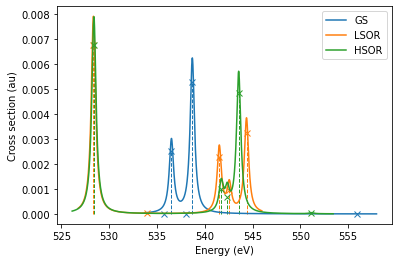

In [55]:
plt.figure()
adc_gs.plot_spectrum(label='GS')
adc_ls.plot_spectrum(label='LSOR')
adc_hs.plot_spectrum(label='HSOR')
plt.legend(); plt.show()


## MOM approaches

*Maybe include:* comparing MOM and IMOM (thanks to Anna Kristina and Josefine):

```{note}
Currently just one version.
```

In [2]:
def imom(mf, mocoeffs, occnum):
    '''Use initial maximum overlap method to determine occupation number for each orbital in every
    iteration. It can be applied to unrestricted as well as restricted open-shell systems.'''
    
    # Copy initial MO coefficients for occupied orbitals
    # This can be adapted for MOM / IMOM - need to look into
    if (isinstance(mf, dft.rks.RKS) or isinstance(mf, scf.hf.RHF)):
        coef_occ_a = mocoeffs[:, occnum>0]
    elif (isinstance(mf, dft.uks.UKS) or isinstance(mf, scf.uhf.UHF)):
        coef_occ_a = mocoeffs[0][:, occnum[0]>0]
        coef_occ_b = mocoeffs[1][:, occnum[1]>0]
        
    # Write new get_occ routine for DFT kernel
    def get_occ(mo_energy=None, mo_coeff=None):
        # Get new MO energy and coefficients
        if mo_energy is None: mo_energy = mf.mo_energy
        if mo_coeff is None: mo_coeff = mf.mo_coeff
        
        # Restricted
        if (isinstance(mf, dft.rks.RKS) or isinstance(mf, scf.hf.RHF)):   
            mo_occ = np.zeros_like(occnum)
            nocc_a = int(np.sum(occnum)/2) # number of occupied orbitals
            
            # Construct s_a = MO_coeff(old)*S*MO_coeff(new)
            SC = np.matmul(mf.get_ovlp().T,mo_coeff)
            s_a = np.matmul(coef_occ_a.T, SC)
            
            # Get indices for orbitals with largest p = sum_i s_a(ij)s_a(ij)
            idx_a = np.argsort(np.einsum('ij,ij->j', s_a, s_a))[::-1]
            
            # Set occupation for selected MOs
            mo_occ[idx_a[:nocc_a]] = 2.
            
        elif (isinstance(mf, dft.uks.UKS) or isinstance(mf, scf.uhf.UHF)):
            mo_occ = np.zeros_like(occnum)
            nocc_a = int(np.sum(occnum[0])) # number of occupied alpha orbitals
            nocc_b = int(np.sum(occnum[1])) # number of occupied beta orbitals
            
            # Construct s_a = MO_coeff(old)*S*MO_coeff(new)
            SC_a = np.matmul(mf.get_ovlp().T,mo_coeff[0])
            s_a = np.matmul(coef_occ_a.T, SC_a)
            # Likewise for s_b
            SC_b = np.matmul(mf.get_ovlp().T,mo_coeff[1])
            s_b = np.matmul(coef_occ_b.T, SC_b)
            
            # Get indices for orbitals with largest p_a = sum_i s_a(ij)s_a(ij)
            idx_a = np.argsort(np.einsum('ij,ij->j', s_a, s_a))[::-1]
            # Likewise for p_b
            idx_b = np.argsort(np.einsum('ij,ij->j', s_b, s_b))[::-1]
            
            # Set occupation for selected MOs
            mo_occ[0][idx_a[:nocc_a]] = 1.
            mo_occ[1][idx_b[:nocc_b]] = 1.

        return mo_occ
    
    # Redefine get_occ for DFT kernel as new function
    mf.get_occ = get_occ
    
    return mf

Example: single and double ionization energy of water.

In [10]:
water_xyz = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

# Create molecule object 
mol = gto.Mole()
mol.atom  = water_xyz
mol.basis = 'STO-3G'
mol.build()

# Index of core MO
core = 0

# Initial restricted/unrestricted SCF
dft_re = dft.RKS(mol); dft_re.xc = 'b3lyp'; dft_re.kernel()
dft_ur = dft.UKS(mol); dft_ur.xc = 'b3lyp'; dft_ur.kernel()

# Single ionization energy
mo0 = copy.deepcopy(dft_ur.mo_coeff)
occ0 = copy.deepcopy(dft_ur.mo_occ)
occ0[0][core] = 0.0
dft_ion = dft.UKS(mol)
dft_ion.xc = 'b3lyp'
imom(dft_ion, mo0, occ0)
dft_ion.kernel()
print('Single ionization energy:',np.around(au2ev*(dft_ion.energy_tot() - dft_gs.energy_tot()),2),'eV')

# Double ionization energy
mo0 = copy.deepcopy(dft_re.mo_coeff)
occ0 = copy.deepcopy(dft_re.mo_occ)
occ0[core] = 0.0
dft_ion = dft.RKS(mol)
dft_ion.xc = 'b3lyp'
imom(dft_ion, mo0, occ0)
dft_ion.kernel()
print('Double ionization energy:',np.around(au2ev*(dft_ion.energy_tot() - dft_gs.energy_tot()),2),'eV')

converged SCF energy = -75.2761808865588
converged SCF energy = -75.2761808866238  <S^2> = 8.8817842e-16  2S+1 = 1
converged SCF energy = -55.3337590090957  <S^2> = 0.7505567  2S+1 = 2.0005566
Single ionization energy: 571.83 eV
converged SCF energy = -31.2166877507321
Double ionization energy: 1228.09 eV


Can compare these values to experiment *etc*.

## Full space vs CVS

In order to illustrate the restricted channel/CVS scheme in TDDFT, we here diagonalize the full-space and CVS-space matrices and compare the resulting spectra.

### Full-space


The linear response function for TDDFT (in TDHF also known as random phase approximation (RPA)), which can be written as

$$
\langle\langle \hat{\mu}_\alpha; \hat{V} \rangle\rangle_\omega =
-{\mu^{[1]}}^\dagger
\Big(
E^{[2]} - \omega S^{[2]}
\Big)^{-1}
V^{[1]},
$$

with $E^{[2]}$ being the electronic Hessian, $\omega$, being the excitation energies and $S^{[2]}$ being the overlap matrix. ${\mu^{[1]}}$ and $V^{[1]}$ are denoted the property gradients. The electronic Hessian, overlap matrix, and property gradient takes the formes:

$$
E^{[2]} = \left(\begin{matrix}
A  &  B \\
B^* &  A\\
\end{matrix}\right),
\qquad
S^{[2]} = \left(\begin{matrix}
1  &  0 \\
1 &  -1\\
\end{matrix}\right),
\qquad
V^{[1]} = \left(\begin{matrix}
g   \\
g^* \\
\end{matrix}\right).
$$
The excitation energies can be determined as the poles of the polarization propagator, i.e. $
\Big(E^{[2]} - \omega S^{[2]}\Big) = 0$, and thus to obtain these, we solve the eigenvalue problem

$$
E^{[2]}X = {\lambda} S^{[2]}X 
$$

where

$$
{\lambda} =\begin{pmatrix}
\lambda & 0\\
0 & -\lambda
\end{pmatrix}
$$

By rewriting the linear response equation, we can identify the transition moment as $X_n^{\dagger}V_{\beta}^{[1]}$, and obtain the oscillator strength as:

$$
(T^{\mu})^{2} = \sum_{\beta=x,y,z}{\mu_{\beta}^{[1]}}^\dagger X_n X_n^{\dagger}\mu_{\beta}^{[1]}\\
f_{osc}^{if} = \frac{2}{3}\cdot \omega_{if}\cdot(T^{\mu})^2
$$

In [3]:
water_xyz = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""
basis = 'sto-3g'
vlx_mol = vlx.Molecule.read_str(water_xyz, units='angstrom')
vlx_bas = vlx.MolecularBasis.read(vlx_mol, basis)

scf_drv = vlx.ScfRestrictedDriver()
scf_settings = {'conv_thresh': 1.0e-6}
method_settings = {'xcfun': 'b3lyp'}
scf_drv.update_settings(scf_settings,method_settings)
scf_drv.compute(vlx_mol, vlx_bas)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Kohn-Sham                                            
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

Loading Hessian and property gradients and constructing overlap matrix:

In [22]:
lrs = vlx.LinearResponseEigenSolver()
lrs.update_settings(scf_settings, method_settings)
rsp_drv = vlx.LinearResponseSolver()
rsp_drv.update_settings(scf_settings, method_settings)

# Electronic Hessian
E2 = lrs.get_e2(vlx_mol, vlx_bas, scf_drv.scf_tensors)

# Property gradients for dipole operator
V1_x = rsp_drv.get_prop_grad('electric dipole', 'x', vlx_mol, vlx_bas, scf_drv.scf_tensors)[0]
V1_y = rsp_drv.get_prop_grad('electric dipole', 'y', vlx_mol, vlx_bas, scf_drv.scf_tensors)[0]
V1_z = rsp_drv.get_prop_grad('electric dipole', 'z', vlx_mol, vlx_bas, scf_drv.scf_tensors)[0]

# Dimension
c = int(len(E2) / 2)

# Overlap matrix
S2 = np.identity(2*c)
S2[c:2*c,c:2*c] *= -1

                                                                                                                          
* Info * Molecular grid with 35950 points generated in 0.01 sec.                                                          
                                                                                                                          
* Info * Processing Fock builds... (batch size: 40)                                                                       
* Info *   batch 1/1                                                                                                      
10


In [25]:
## Full diagonalization

# Set up and solve eigenvalue problem
Sinv = np.linalg.inv(S2) # for clarity - is identical
M = np.matmul(Sinv, E2)
eigs, X = np.linalg.eig(M)

# Reorder results
idx = np.argsort(eigs)
eigs = np.array(eigs)[idx]
X = np.array(X)[:,idx]

# Compute oscillator strengths
fosc = []
for i in range(int(len(eigs)/2)):
    j = i + int(len(eigs)/2) # focus on excitations
    Xf = X[:,j]
    Xf = Xf / np.sqrt(np.matmul(Xf.T, np.matmul(S2, Xf)))
    tm = np.dot(Xf, V1_x)**2+np.dot(Xf, V1_y)**2+np.dot(Xf, V1_z)**2
    fosc.append(tm*2.0/3.0*eigs[j])

In [27]:
au2ev = 27.211396

print(f'Energy/eV    Osc. strength')
print(f'---------------------------')
for i in range(int(len(eigs)/2)):
    j = i + int(len(eigs)/2) # focus on excitations
    print(f' {au2ev*eigs[j] : .2f}        {fosc[i] : .5f}')
print(f'---------------------------')

Energy/eV    Osc. strength
---------------------------
  11.57         0.00115
  13.86         0.00000
  14.45         0.03201
  17.77         0.02945
  21.44         0.47266
  26.74         0.21261
  36.77         0.07077
  36.91         0.02925
  519.02         0.02692
  521.26         0.04340
---------------------------


### CVS space

In [32]:
## Indices and dimensions

# VUmber of virtuals
nocc = vlx_mol.number_of_alpha_electrons()
nvirt = vlx.MolecularBasis.get_dimensions_of_basis(vlx_bas, vlx_mol) - nocc
n = nocc * nvirt

# CVS space
res_mo = 1
res_indx = 0
c = res_mo * nvirt

In [33]:
## Construct CVS objects

# Define starting index for deexcitation
c_int_deex = n + res_indx

# CVS Hessian
E2_cvs = np.zeros((2 * c, 2 * c))
E2_cvs[0:c, 0:c] = E2[res_indx:c, res_indx:c]
E2_cvs[0:c, c:2*c] = E2[res_indx:c, c_int_deex:c_int_deex+c]
E2_cvs[c:2*c, 0:c] = E2[c_int_deex:c_int_deex+c, res_indx:c]
E2_cvs[c:2*c, c:2*c] = E2[c_int_deex:c_int_deex+c, c_int_deex:c_int_deex+c]

# CVS overlap matrix
S2_cvs = np.identity(2*c)
S2_cvs[c:2*c,c:2*c] *= -1

# CVS property gradients
V1_cvs_x = np.zeros(2*c); V1_cvs_x[0:c] = V1_x[res_indx:c]; V1_cvs_x[c:2*c] = V1_x[c_int_deex:c_int_deex+c]
V1_cvs_y = np.zeros(2*c); V1_cvs_y[0:c] = V1_y[res_indx:c]; V1_cvs_y[c:2*c] = V1_y[c_int_deex:c_int_deex+c]
V1_cvs_z = np.zeros(2*c); V1_cvs_z[0:c] = V1_z[res_indx:c]; V1_cvs_z[c:2*c] = V1_z[c_int_deex:c_int_deex+c]

In [34]:
## Full diagonalization in CVS space

# Set up and solve eigenvalue problem
Sinv = np.linalg.inv(S2_cvs) # for clarity - is identical
M = np.matmul(Sinv, E2_cvs)
eigs_cvs, X_cvs = np.linalg.eig(M)

# Reorder results
idx = np.argsort(eigs_cvs)
eigs_cvs = np.array(eigs_cvs)[idx]
X_cvs = np.array(X_cvs)[:,idx]

# Compute oscillator strengths
fosc_cvs = []
for i in range(int(len(eigs_cvs)/2)):
    j = i + int(len(eigs_cvs)/2) # focus on excitations
    Xf_cvs = X_cvs[:,j]
    Xf_cvs = Xf_cvs / np.sqrt(np.matmul(Xf_cvs.T, np.matmul(S2_cvs, Xf_cvs)))
    tm_cvs = np.dot(Xf_cvs, V1_cvs_x)**2+np.dot(Xf_cvs, V1_cvs_y)**2+np.dot(Xf_cvs, V1_cvs_z)**2
    fosc_cvs.append(tm_cvs*2.0/3.0*eigs_cvs[j])

In [35]:
## Print and plot results

au2ev = 27.211396

print(f'Energy/eV    Osc. strength')
print(f'---------------------------')
for i in range(int(len(eigs_cvs)/2)):
    j = i + int(len(eigs_cvs)/2) # focus on excitations
    print(f' {au2ev*eigs_cvs[j] : .2f}        {fosc_cvs[i] : .5f}')
print(f'---------------------------')

Energy/eV    Osc. strength
---------------------------
  519.02         0.02669
  521.26         0.04305
---------------------------


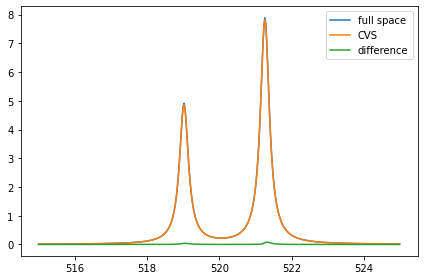

In [50]:
# Plot both sets

def lorentzian(x, y, xmin, xmax, xstep, gamma):
    xi = np.arange(xmin,xmax,xstep); yi=np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)): yi[i] = yi[i] + y[k] * (gamma/2.) / ( (xi[i]-x[k])**2 + (gamma/2.)**2 )
    return xi,yi

plt.figure()
x,y = eigs[int(len(eigs)/2):], fosc
x1,y1 = lorentzian(x,y,515/au2ev, 525/au2ev,0.001,0.3/au2ev); plt.plot(x1*au2ev,y1)
x,y = eigs_cvs[int(len(eigs_cvs)/2):], fosc_cvs
x2,y2 = lorentzian(x,y,515/au2ev, 525/au2ev,0.001,0.3/au2ev); plt.plot(x2*au2ev,y2)
plt.plot(x2*au2ev,y1 - y2)
plt.legend(('full space','CVS','difference'))

plt.tight_layout(); plt.show()

- Compare to functions in veloxchem
- Can also consider TDA (and compare)

## XAS in reverse

One can also simply consider the XAS process in reverse, i.e. preparing a core excited state and determining the deexcitation energy and oscillator strength. 

```{note}
Might remove - this approach is of no real practical use, and need to consider if it makes any sense...
```

In [66]:
xas_ls_E = []
xas_ls_f = []
xas_hs_E = []
xas_hs_f = []

# Perform unrestricted SCF calculation
scf_res = scf.UHF(mol)
scf_res.kernel()

# Copy molecular orbital coefficients
mo0 = copy.deepcopy(scf_res.mo_coeff)

# LSOR
for i in range(2):
    # Copy molecular occupations and core excite from 1s alpha to a valence state
    occ0 = copy.deepcopy(scf_res.mo_occ)
    occ0[0][0] = 0.0
    occ0[0][5+i] = 1.0
    # Perform unrestricted SCF calculation with MOM constraint
    scf_ion = scf.UHF(mol)
    scf.addons.mom_occ(scf_ion, mo0, occ0)
    scf_ion.kernel()
    # Perform ADC calculation of first four states
    adc_xas = adcc.adc2(scf_ion, n_states = 1)
    xas_ls_E.append(-au2ev*adc_xas.excitation_energy) 
    xas_ls_f.append(adc_xas.oscillator_strength)
    
# HSOR
for i in range(2):
    # Copy molecular occupations and core excite from 1s alpha to a valence state
    occ0 = copy.deepcopy(scf_res.mo_occ)
    occ0[0][0] = 0.0
    occ0[1][5+i] = 1.0
    # Perform unrestricted SCF calculation with MOM constraint
    scf_ion = scf.UHF(mol)
    scf.addons.mom_occ(scf_ion, mo0, occ0)
    scf_ion.kernel()
    # Perform ADC calculation of first four states
    adc_xas = adcc.adc2(scf_ion, n_states = 1)
    xas_hs_E.append(-au2ev*adc_xas.excitation_energy) 
    xas_hs_f.append(adc_xas.oscillator_strength)

converged SCF energy = -75.9838703827192  <S^2> = 6.3415939e-12  2S+1 = 1
converged SCF energy = -56.2454489455331  <S^2> = 1.0207474  2S+1 = 2.2545486
Starting adc2  Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     4       0.94633   3.0s  [-19.28664166]
  2     8      0.040054   76ms  [-19.67599841]
  3    12     0.0019786   63ms  [-19.68727678]
  4    16    1.8034e-05   87ms  [-19.68756532]
=== Converged ===
    Number of matrix applies:    16
    Total solver time:             3s 186ms
converged SCF energy = -56.1667062608725  <S^2> = 1.0169051  2S+1 = 2.2511376
Starting adc2  Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     4       0.97754   3.2s  [-19.41096808]
  2     8      0.004881  117ms  [-19.76424561]
  3    12    2.6171e-07   73ms  [-19.7649555]
=== Converged ===
    Number of matrix applies:    12
    Total solver time:             3s 396ms
converged SCF energy = -56.2574562996861  <S^2> = 2.0096735  2S+1 = 3.0064421
Starting a

+--------------------------------------------------------------+
| cvs-adc2x                                   any ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au)           (eV)                                 |
|  0      19.68908      535.7671   0.0000    0.8089    0.1911  |
|  1      19.71642      536.5111   0.0174    0.8001    0.1999  |
|  2      19.77248      538.0366   0.0000    0.8215    0.1785  |
|  3       19.7967      538.6957   0.0368    0.8088    0.1912  |
|  4      20.43113      555.9592   0.0000    0.8504    0.1496  |
+--------------------------------------------------------------+


Excitation Energy/eV     Osc. strength
-------------------------------------------
    535.73                    0.011365
    537.83                    0.022696
-------------------------------------------

Excitation Energy/eV     Osc. strength
--------------------------------------

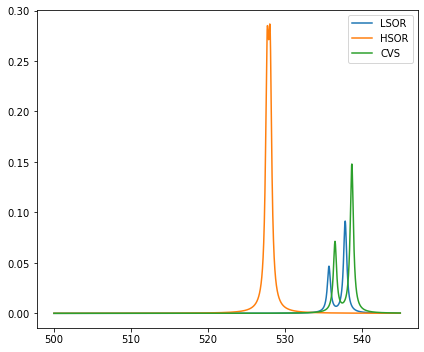

In [73]:
print(adc_gs.describe())

print(f'\nExcitation Energy/eV     Osc. strength')
print(f'-------------------------------------------')
for i in range(len(xas_ls_E)):
    print(f'   {xas_ls_E[i][0] : .2f}                   {xas_ls_f[i][0] : .6f}')
print(f'-------------------------------------------')

print(f'\nExcitation Energy/eV     Osc. strength')
print(f'-------------------------------------------')
for i in range(len(xas_hs_E)):
    print(f'   {xas_hs_E[i][0] : .2f}                   {xas_hs_f[i][0] : .6f}')
print(f'-------------------------------------------')

plt.figure(figsize=(6,5))
x,y = xas_ls_E, xas_ls_f
xi,yi = lorentzian(x,y,500,545,0.01,0.5); plt.plot(xi,yi)
x,y = xas_hs_E, xas_hs_f
xi,yi = lorentzian(x,y,500,545,0.01,0.5); plt.plot(xi,yi)
x = au2ev*adc_gs.excitation_energy 
y = adc_gs.oscillator_strength
xi,yi = lorentzian(x,y,500,545,0.01,0.5); plt.plot(xi,yi)
plt.legend(('LSOR','HSOR','CVS'))
plt.tight_layout(); plt.show()

## XES in reverse

The XES process can like the XAS process be considered in reverse and thus calculated from core excitation of a valence ionized state, rather than from valence deexcitations of a core ionized state.

In [5]:
xes_rev_E = []
xes_rev_f = []

# Perform unrestricted SCF calculation
scf_res = scf.UHF(mol)
scf_res.kernel()

# Copy molecular orbital coefficients
mo0 = copy.deepcopy(scf_res.mo_coeff)

for i in range(4):
    occ0 = copy.deepcopy(scf_res.mo_occ)
    occ0[0][4-i] = 0.0
    # Perform unrestricted SCF calculation with MOM constraint
    scf_ion = scf.UHF(mol)
    scf.addons.mom_occ(scf_ion, mo0, occ0)
    scf_ion.kernel()
    # Perform ADC calculation of first four states
    adc_xes = adcc.cvs_adc2(scf_ion, n_states = 1, core_orbitals=1)
    xes_rev_E.append(au2ev*adc_xes.excitation_energy) 
    xes_rev_f.append(adc_xes.oscillator_strength)

converged SCF energy = -75.9838703827191  <S^2> = 6.3398176e-12  2S+1 = 1
converged SCF energy = -75.5809306304762  <S^2> = 0.75536251  2S+1 = 2.0053553
Starting cvs-adc2  Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     4        1.0539   1.6s  [19.86337216]
  2     8       0.04208  141ms  [19.52863384]
  3    12    0.00013686   97ms  [19.51785025]
=== Converged ===
    Number of matrix applies:    12
    Total solver time:             1s 852ms
converged SCF energy = -75.5087995224459  <S^2> = 0.75179447  2S+1 = 2.0017937
Starting cvs-adc2  Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     4        1.0608   1.6s  [19.78797676]
  2     8      0.035086   67ms  [19.45415671]
  3    12    0.00036322  107ms  [19.44536161]
  4    16    3.8872e-05   94ms  [19.4452592]
=== Converged ===
    Number of matrix applies:    16
    Total solver time:             1s 847ms
converged SCF energy = -75.3327322228837  <S^2> = 0.7534135  2S+1 = 2.0034106
Startin

In [6]:
# From a core-hole

occ0 = copy.deepcopy(scf_res.mo_occ)
occ0[0][0] = 0.0

scf_ion = scf.UHF(mol)
scf.addons.mom_occ(scf_ion, mo0, occ0)
scf_ion.kernel()
adc_xes = adcc.adc2(scf_ion, n_states = 4)
xes_E = -au2ev*adc_xes.excitation_energy
xes_f = adc_xes.oscillator_strength

converged SCF energy = -56.0754789470865  <S^2> = 0.76257805  2S+1 = 2.0125387
Starting adc2  Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8       0.77768   1.6s  [-19.29082067 -19.19940205 -18.96181907 -18.3637012 ]
  2    16     0.0010764  174ms  [-19.44427093 -19.36689642 -19.16826546 -18.57947501]
  3    24    4.4301e-07  230ms  [-19.44429764 -19.3669284  -19.16831914 -18.57954987]
=== Converged ===
    Number of matrix applies:    24
    Total solver time:             1s 975ms



Excitation Energy/eV     Osc. strength
-------------------------------------------
    529.11                    0.056837
    529.11                    0.056837
    529.11                    0.056837
    529.11                    0.056837
-------------------------------------------

Excitation Energy/eV     Osc. strength
-------------------------------------------
    531.11                    0.052749
    529.13                    0.043016
    524.44                    0.039244
    508.03                    0.003644
-------------------------------------------


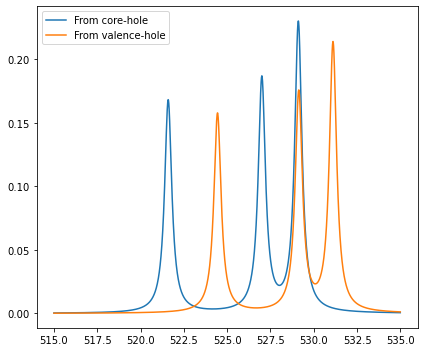

In [9]:
print(f'\nExcitation Energy/eV     Osc. strength')
print(f'-------------------------------------------')
for i in range(len(xes_E)):
    print(f'   {xes_E[0] : .2f}                   {xes_f[0] : .6f}')
print(f'-------------------------------------------')

print(f'\nExcitation Energy/eV     Osc. strength')
print(f'-------------------------------------------')
for i in range(len(xes_rev_E)):
    print(f'   {xes_rev_E[i][0] : .2f}                   {xes_rev_f[i][0] : .6f}')
print(f'-------------------------------------------')

# Plot
plt.figure(figsize=(6,5))
x,y = xes_E, xes_f
xi,yi = lorentzian(x,y,515,535,0.01,0.5); plt.plot(xi,yi)
x,y = xes_rev_E, xes_rev_f
xi,yi = lorentzian(x,y,515,535,0.01,0.5); plt.plot(xi,yi)
plt.legend(('From core-hole','From valence-hole'))
plt.tight_layout(); plt.show()